In [1]:
%%capture
from pathlib import Path

if Path.cwd().stem == "features":
    %cd ../..
    %load_ext autoreload
    %autoreload 2

In [2]:
import logging

import holoviews as hv
import hvplot.pandas  # noqa
import neurokit2 as nk
import pandas as pd
import polars as pl
from icecream import ic
from polars import col

from src.data.database_manager import DatabaseManager
from src.features.quality_checks import check_sample_rate
from src.features.scaling import scale_min_max
from src.features.transformations import add_time_column, map_trials
from src.log_config import configure_logging

configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado"],
)

pl.Config.set_tbl_rows(12)  # for the 12 trials
hv.output(widget_location="bottom", size=130)

In [4]:
db = DatabaseManager()

In [5]:
with db:
    df = db.read_table("Raw_Stimulus")
df

trial_id,trial_number,participant_id,rownumber,timestamp,temperature,rating
u16,u8,u8,u32,f64,f64,f64
1,1,1,0,294224.331,45.75,42.5
1,1,1,1,294357.9645,45.750102,42.5
1,1,1,2,294458.0292,45.75041,35.375
1,1,1,3,294558.6006,45.750922,14.875
1,1,1,4,294658.3354,45.751639,10.125
1,1,1,5,294758.4957,45.75256,22.75
…,…,…,…,…,…,…
332,12,28,21606,2.7766e6,45.587356,85.0
332,12,28,21607,2.7767e6,45.585285,85.0


In [6]:
with db:
    df = db.read_table("Preprocessocess_EDA")
df

trial_id,trial_number,participant_id,rownumber,timestamp,samplenumber,eda_d_battery,eda_raw,eda_d_packetreceptionrate
u16,u8,u8,u32,f64,i64,f64,f64,i64
1,1,1,37660,294210.3603,57892,3686.174359,0.752359,100
1,1,1,37661,294211.3575,57893,3693.45641,0.754579,100
1,1,1,37663,294224.331,57895,3677.435897,0.753247,100
1,1,1,37664,294242.275,57896,3687.630769,0.754135,100
1,1,1,37666,294248.2588,57898,3692.0,0.754135,100
1,1,1,37667,294276.1835,57899,3678.892308,0.754135,100
…,…,…,…,…,…,…,…,…
332,12,28,355476,2.7771e6,467073,3603.158974,13.679468,99
332,12,28,355477,2.7771e6,467074,3617.723077,13.679468,99


In [7]:
query = """
SELECT * FROM Preprocess_EDA AS ce
ASOF JOIN Raw_Stimulus rs USING (trial_id, timestamp)
ORDER BY ce.trial_id, ce.timestamp
"""

with db:
    df = db.execute(query).pl()
df
ic(df.height, df.unique("timestamp").height)
ic(df.height - df.unique("timestamp").height)
df

ic| df.height: 5934569, df.unique("timestamp").height: 5934569
ic| df.height - df.unique("timestamp").height: 0


trial_id,trial_number,participant_id,rownumber,timestamp,samplenumber,eda_d_battery,eda_raw,eda_d_packetreceptionrate,temperature,rating
u16,u8,u8,u32,f64,i64,f64,f64,i64,f64,f64
1,1,1,0,294224.331,57895,3677.435897,0.753247,100,45.75,42.5
1,1,1,0,294242.275,57896,3687.630769,0.754135,100,45.75,42.5
1,1,1,0,294248.2588,57898,3692.0,0.754135,100,45.75,42.5
1,1,1,0,294276.1835,57899,3678.892308,0.754135,100,45.75,42.5
1,1,1,0,294277.1819,57900,3692.0,0.752359,100,45.75,42.5
1,1,1,0,294309.0952,57902,3705.107692,0.752359,100,45.75,42.5
…,…,…,…,…,…,…,…,…,…,…
332,12,28,21610,2.7771e6,467073,3603.158974,13.679468,99,45.582614,85.0
332,12,28,21610,2.7771e6,467074,3617.723077,13.679468,99,45.582614,85.0


In [52]:
query = """
SELECT * FROM Preprocess_EDA AS ce
ASOF JOIN Raw_Stimulus rs 
       ON ce.trial_id = rs.trial_id
      AND ce.timestamp >= rs.timestamp
ORDER BY ce.trial_id, ce.timestamp
"""
query = """
SELECT * FROM Preprocess_EDA AS ce
ASOF JOIN Raw_Stimulus rs 
            ON ce.trial_id = rs.trial_id
           AND ce.timestamp >= rs.timestamp
ORDER BY ce.trial_id, ce.timestamp
"""
query = """
SELECT * FROM Preprocess_EDA AS ce
ASOF JOIN Raw_Stimulus rs 
       ON ce.trial_id = rs.trial_id
      AND rs.timestamp >= ce.timestamp
ORDER BY ce.trial_id, ce.timestamp
"""

In [53]:
@map_trials
def nk_process_eda(
    df: pl.DataFrame,
    sampling_rate: int = 100,
) -> pl.DataFrame:
    eda_raw = df.select("eda_raw").to_numpy().flatten()
    eda_processed: pd.DataFrame = nk.eda_phasic(
        eda_signal=eda_raw,
        sampling_rate=sampling_rate,
        method="neurokit",
    )  # this returns EDA_Phasic and EDA_Tonic columns
    return df.hstack(pl.from_pandas(eda_processed))


df = nk_process_eda(df)
df

trial_id,trial_number,participant_id,rownumber,timestamp,samplenumber,eda_d_battery,eda_raw,eda_d_packetreceptionrate,temperature,rating,EDA_Tonic,EDA_Phasic
u16,u8,u8,u32,f64,i64,f64,f64,i64,f64,f64,f64,f64
1,1,1,0,294224.331,57895,3677.435897,0.753247,100,45.75,42.5,0.752782,0.000465
1,1,1,0,294242.275,57896,3687.630769,0.754135,100,45.75,42.5,0.752783,0.001352
1,1,1,0,294248.2588,57898,3692.0,0.754135,100,45.75,42.5,0.752783,0.001352
1,1,1,0,294276.1835,57899,3678.892308,0.754135,100,45.75,42.5,0.752784,0.001351
1,1,1,0,294277.1819,57900,3692.0,0.752359,100,45.75,42.5,0.752784,-0.000425
1,1,1,0,294309.0952,57902,3705.107692,0.752359,100,45.75,42.5,0.752785,-0.000426
…,…,…,…,…,…,…,…,…,…,…,…,…
332,12,28,21610,2.7771e6,467073,3603.158974,13.679468,99,45.582614,85.0,13.578895,-0.012186
332,12,28,21610,2.7771e6,467074,3617.723077,13.679468,99,45.582614,85.0,13.578895,-0.012764


In [54]:
(df).plot(
    x="timestamp",
    y=["eda_raw", "EDA_Phasic", "EDA_Tonic", "rating", "temperature"],
    title="EDA signal",
    groupby="trial_id",
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'d7e7015b-ae94-4481-bd66-e0f2d56787b1': {'version…

In [61]:
scale_min_max(df).plot(
    x="timestamp",
    y=["eda_raw", "EDA_Phasic", "EDA_Tonic", "rating", "temperature"],
    title="EDA signal",
    groupby="trial_id",
    widget_location="bottom",
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'614f89f1-51f2-4647-83bb-08b0ed2f7c31': {'version…

In [67]:
check_sample_rate(df)

10:31:06 | DEBUG   | quality_checks | Sample rate per trial: [ 97.89  98.81  98.72  98.69  98.85  98.98  98.52  98.73  98.62  98.91
  98.55  98.71 100.41 100.75 100.65 100.68 100.71 100.45 100.57 100.62
 100.69 100.49 100.69 100.39  99.03  99.    99.    98.92  99.23  98.69
  99.09  98.84  99.25  98.82  98.93  99.09  99.06  98.92  99.19  99.1
  99.23  99.12  99.31  98.88  98.74  98.77  98.69  98.78  98.52  98.78
  98.59  98.5   98.69  98.62  98.72  98.59  98.69  98.81  99.01  98.66
  98.64  98.63  98.92  98.97  98.89  98.81  98.88  98.86  99.17  99.14
  98.8   98.97  98.98  98.85  99.07  99.    98.79  98.74  98.76  98.67
  98.9   98.74  98.93  98.71  98.9   98.8   98.59  98.88  98.8   98.72
  98.74  98.61 100.52 100.53 100.48 100.52 100.68 100.66 100.65 100.56
 100.63 100.6  100.59 100.59  98.6   98.92  98.54  98.81  98.75  98.73
  98.68  98.84  98.63  98.83  98.57  98.55  98.94  98.81  98.91  98.97
  99.01  98.95  98.97  98.92  98.86  98.78  98.8   98.66  98.89  98.4
  98.69  98.95  98

In [56]:
# Time columns

In [57]:
df = add_time_column(df)

In [58]:
df = df.with_columns(
    (col("timestamp") * 1000).cast(pl.Int64).alias("timestamp_us"),
)

In [59]:
df

trial_id,trial_number,participant_id,rownumber,timestamp,samplenumber,eda_d_battery,eda_raw,eda_d_packetreceptionrate,temperature,rating,EDA_Tonic,EDA_Phasic,time,timestamp_us
u16,u8,u8,u32,f64,i64,f64,f64,i64,f64,f64,f64,f64,duration[ms],i64
1,1,1,0,294224.331,57895,3677.435897,0.753247,100,45.75,42.5,0.752782,0.000465,4m 54s 224ms,294224331
1,1,1,0,294242.275,57896,3687.630769,0.754135,100,45.75,42.5,0.752783,0.001352,4m 54s 242ms,294242275
1,1,1,0,294248.2588,57898,3692.0,0.754135,100,45.75,42.5,0.752783,0.001352,4m 54s 248ms,294248258
1,1,1,0,294276.1835,57899,3678.892308,0.754135,100,45.75,42.5,0.752784,0.001351,4m 54s 276ms,294276183
1,1,1,0,294277.1819,57900,3692.0,0.752359,100,45.75,42.5,0.752784,-0.000425,4m 54s 277ms,294277181
1,1,1,0,294309.0952,57902,3705.107692,0.752359,100,45.75,42.5,0.752785,-0.000426,4m 54s 309ms,294309095
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
332,12,28,21610,2.7771e6,467073,3603.158974,13.679468,99,45.582614,85.0,13.578895,-0.012186,46m 17s 66ms,2777066747
332,12,28,21610,2.7771e6,467074,3617.723077,13.679468,99,45.582614,85.0,13.578895,-0.012764,46m 17s 80ms,2777080710


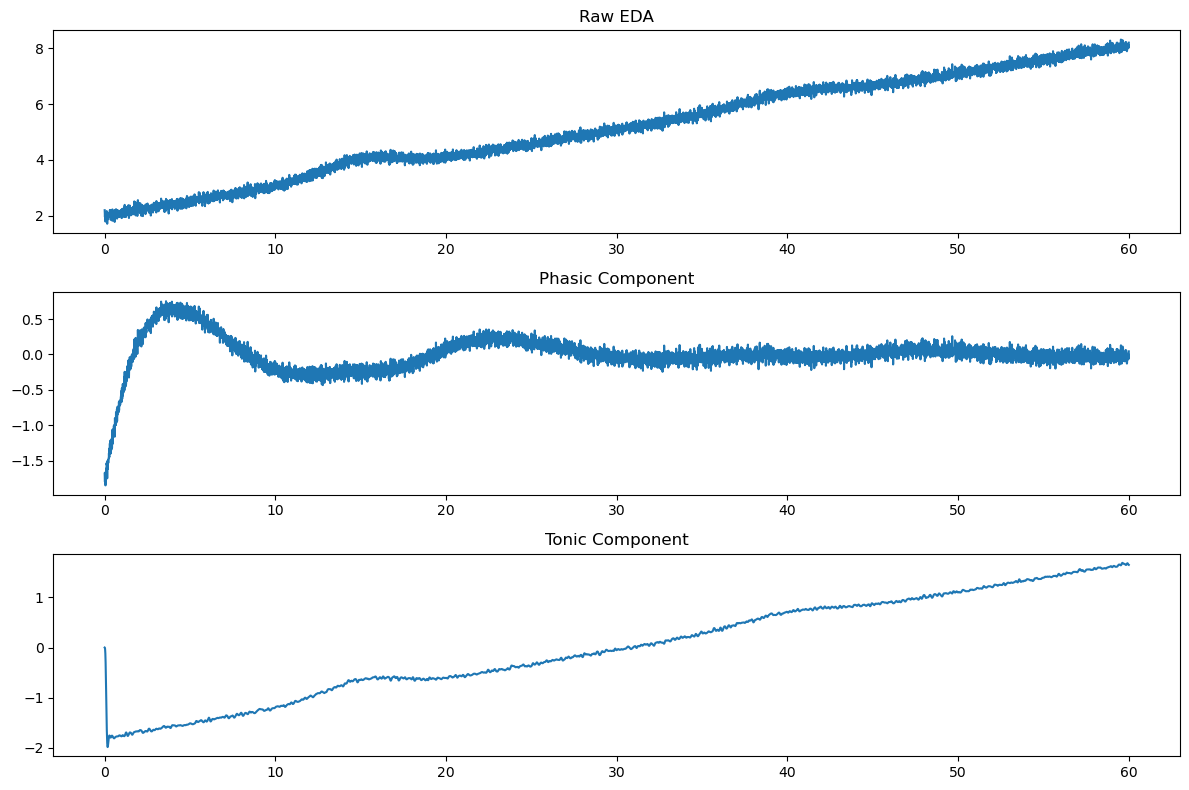

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal


def ledalab_transform(raw_eda, sample_rate=128, lowpass_freq=5, highpass_freq=0.05):
    """
    Perform a simplified Ledalab-like transformation on raw EDA data.

    Parameters:
    raw_eda (array): Raw EDA signal
    sample_rate (int): Sampling rate of the EDA signal in Hz
    lowpass_freq (float): Cutoff frequency for lowpass filter
    highpass_freq (float): Cutoff frequency for highpass filter

    Returns:
    tuple: (phasic_eda, tonic_eda)
    """

    # Normalize the signal
    normalized_eda = (raw_eda - np.mean(raw_eda)) / np.std(raw_eda)

    # Design lowpass filter
    lowpass = signal.butter(4, lowpass_freq, btype="low", fs=sample_rate, output="sos")

    # Apply lowpass filter to get tonic component
    tonic_eda = signal.sosfilt(lowpass, normalized_eda)

    # Design highpass filter
    highpass = signal.butter(
        4, highpass_freq, btype="high", fs=sample_rate, output="sos"
    )

    # Apply highpass filter to get phasic component
    phasic_eda = signal.sosfilt(highpass, normalized_eda)

    return phasic_eda, tonic_eda


# Example usage
def generate_sample_eda(duration=60, sample_rate=128):
    """Generate a sample EDA signal for demonstration"""
    t = np.linspace(0, duration, duration * sample_rate)
    tonic = 2 + 0.1 * t + 0.1 * np.sin(2 * np.pi * 0.005 * t)
    phasic = 0.5 * np.exp(-((t - 15) ** 2) / 10) + 0.3 * np.exp(-((t - 40) ** 2) / 15)
    noise = 0.1 * np.random.randn(len(t))
    return tonic + phasic + noise


# Generate sample data
sample_rate = 128
raw_eda = generate_sample_eda(duration=60, sample_rate=sample_rate)

# Apply the transformation
phasic, tonic = ledalab_transform(raw_eda, sample_rate=sample_rate)

# Plot the results
t = np.linspace(0, 60, len(raw_eda))
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(t, raw_eda)
plt.title("Raw EDA")
plt.subplot(3, 1, 2)
plt.plot(t, phasic)
plt.title("Phasic Component")
plt.subplot(3, 1, 3)
plt.plot(t, tonic)
plt.title("Tonic Component")
plt.tight_layout()
plt.show()

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize


def cda_ledalab(raw_eda, sample_rate=128, tau=0.7, impulse_duration=10):
    """
    Perform Continuous Decomposition Analysis (CDA) on raw EDA data.

    Parameters:
    raw_eda (array): Raw EDA signal
    sample_rate (int): Sampling rate of the EDA signal in Hz
    tau (float): Time constant for the impulse response function
    impulse_duration (float): Duration of the impulse response in seconds

    Returns:
    tuple: (phasic_eda, tonic_eda, driver)
    """

    # Normalize the signal
    normalized_eda = (raw_eda - np.min(raw_eda)) / (np.max(raw_eda) - np.min(raw_eda))

    # Create time array
    t = np.arange(len(normalized_eda)) / sample_rate

    # Create impulse response function
    t_impulse = np.arange(0, impulse_duration, 1 / sample_rate)
    impulse_response = (t_impulse / tau) * np.exp(-t_impulse / tau)
    impulse_response /= np.sum(impulse_response)

    # Deconvolution to get driver signal
    driver = signal.deconvolve(normalized_eda, impulse_response)[0]

    # Ensure driver is non-negative
    driver = np.maximum(driver, 0)

    # Optimize tonic component
    def tonic_error(tonic_params):
        a, b, c = tonic_params
        tonic = a * t**2 + b * t + c
        phasic = normalized_eda - tonic
        reconstructed = np.convolve(phasic, impulse_response, mode="full")[
            : len(phasic)
        ]
        return np.sum((normalized_eda - (tonic + reconstructed)) ** 2)

    # Initial guess for tonic parameters
    initial_guess = [0, 0, np.min(normalized_eda)]

    # Optimize tonic parameters
    result = optimize.minimize(tonic_error, initial_guess, method="L-BFGS-B")
    a, b, c = result.x

    # Compute final tonic and phasic components
    tonic_eda = a * t**2 + b * t + c
    phasic_eda = normalized_eda - tonic_eda

    return phasic_eda, tonic_eda, driver


# Example usage
def generate_sample_eda(duration=60, sample_rate=128):
    """Generate a sample EDA signal for demonstration"""
    t = np.linspace(0, duration, duration * sample_rate)
    tonic = 2 + 0.1 * t + 0.1 * np.sin(2 * np.pi * 0.005 * t)
    phasic = 0.5 * np.exp(-((t - 15) ** 2) / 10) + 0.3 * np.exp(-((t - 40) ** 2) / 15)
    noise = 0.1 * np.random.randn(len(t))
    return tonic + phasic + noise


# Generate sample data
sample_rate = 128
raw_eda = generate_sample_eda(duration=60, sample_rate=sample_rate)

# Apply CDA
phasic, tonic, driver = cda_ledalab(raw_eda, sample_rate=sample_rate)

# Plot the results
t = np.linspace(0, 60, len(raw_eda))
plt.figure(figsize=(12, 10))
plt.subplot(4, 1, 1)
plt.plot(t, raw_eda)
plt.title("Raw EDA")
plt.subplot(4, 1, 2)
plt.plot(t, phasic)
plt.title("Phasic Component")
plt.subplot(4, 1, 3)
plt.plot(t, tonic)
plt.title("Tonic Component")
plt.subplot(4, 1, 4)
plt.plot(t, driver)
plt.title("Driver")
plt.tight_layout()
plt.show()

ValueError: BUG: filter coefficient a[0] == 0 not supported yet

ValueError: x and y must have same first dimension, but have shapes (7680,) and (6401,)

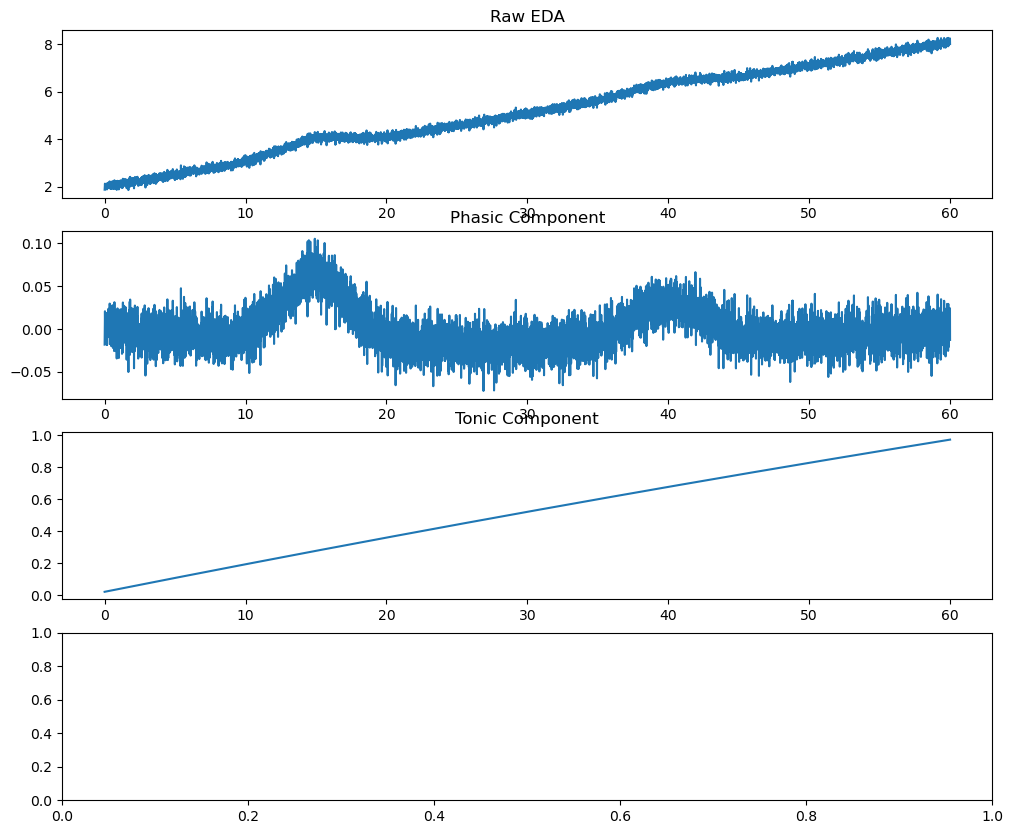

In [3]:
import matplotlib.pyplot as plt
import numpy as np


def cda_ledalab(raw_eda, sample_rate=128, tau=0.7, impulse_duration=10):
    """
    Perform Continuous Decomposition Analysis (CDA) on raw EDA data.

    Parameters:
    raw_eda (array): Raw EDA signal
    sample_rate (int): Sampling rate of the EDA signal in Hz
    tau (float): Time constant for the impulse response function
    impulse_duration (float): Duration of the impulse response in seconds

    Returns:
    tuple: (phasic_eda, tonic_eda, driver)
    """

    # Normalize the signal
    normalized_eda = (raw_eda - np.min(raw_eda)) / (np.max(raw_eda) - np.min(raw_eda))

    # Create time array
    t = np.arange(len(normalized_eda)) / sample_rate

    # Create impulse response function
    t_impulse = np.arange(0, impulse_duration, 1 / sample_rate)
    impulse_response = np.exp(-t_impulse / tau)  # Changed to simple exponential decay
    impulse_response /= np.sum(impulse_response)

    # Deconvolution to get driver signal
    driver = signal.deconvolve(normalized_eda, impulse_response)[0]

    # Ensure driver is non-negative
    driver = np.maximum(driver, 0)

    # Optimize tonic component
    def tonic_error(tonic_params):
        a, b, c = tonic_params
        tonic = a * t**2 + b * t + c
        phasic = normalized_eda - tonic
        reconstructed = np.convolve(phasic, impulse_response, mode="full")[
            : len(phasic)
        ]
        return np.sum((normalized_eda - (tonic + reconstructed)) ** 2)

    # Initial guess for tonic parameters
    initial_guess = [0, 0, np.min(normalized_eda)]

    # Optimize tonic parameters
    result = optimize.minimize(tonic_error, initial_guess, method="L-BFGS-B")
    a, b, c = result.x

    # Compute final tonic and phasic components
    tonic_eda = a * t**2 + b * t + c
    phasic_eda = normalized_eda - tonic_eda

    return phasic_eda, tonic_eda, driver


# Example usage
def generate_sample_eda(duration=60, sample_rate=128):
    """Generate a sample EDA signal for demonstration"""
    t = np.linspace(0, duration, duration * sample_rate)
    tonic = 2 + 0.1 * t + 0.1 * np.sin(2 * np.pi * 0.005 * t)
    phasic = 0.5 * np.exp(-((t - 15) ** 2) / 10) + 0.3 * np.exp(-((t - 40) ** 2) / 15)
    noise = 0.1 * np.random.randn(len(t))
    return tonic + phasic + noise


# Generate sample data
sample_rate = 128
raw_eda = generate_sample_eda(duration=60, sample_rate=sample_rate)

# Apply CDA
phasic, tonic, driver = cda_ledalab(raw_eda, sample_rate=sample_rate)

# Plot the results
t = np.linspace(0, 60, len(raw_eda))
plt.figure(figsize=(12, 10))
plt.subplot(4, 1, 1)
plt.plot(t, raw_eda)
plt.title("Raw EDA")
plt.subplot(4, 1, 2)
plt.plot(t, phasic)
plt.title("Phasic Component")
plt.subplot(4, 1, 3)
plt.plot(t, tonic)
plt.title("Tonic Component")
plt.subplot(4, 1, 4)
plt.plot(t, driver)
plt.title("Driver")
plt.tight_layout()
plt.show()